https://docs.google.com/document/d/1IVDeUUmjDEqmYIRXQSrSwzP6G8Q4oDQnX74M3Pbkwl0/edit?usp=sharing

# Заливка

устанавливаем SQLite последнюю версию

In [ ]:
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so \
    /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so
# then MENU: Runtime > Restart runtime ...

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
sqlite3.sqlite_version

'3.31.1'

Создаем таблицу №1

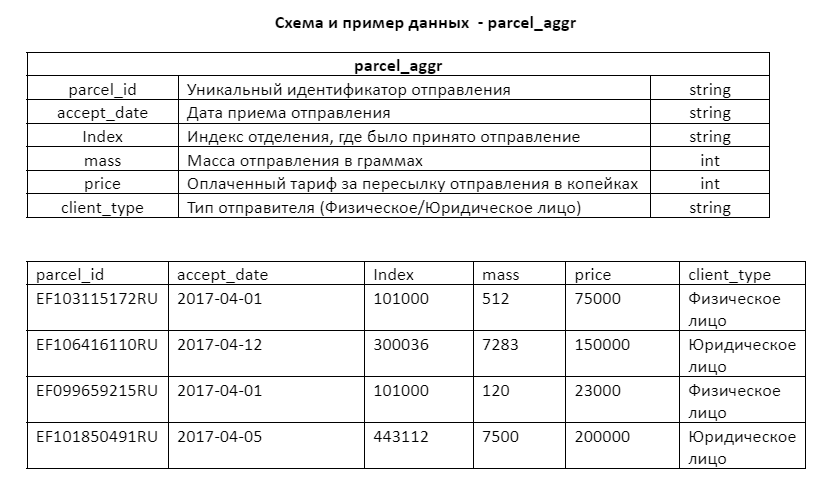

In [3]:
parcel_aggr = pd.DataFrame({'parcel_id':range(100)})

In [4]:
parcel_aggr['accept_date'] = (pd.Series(
                             pd.date_range(start='2017-04-01',end='2017-04-30'))
                             .sample(100,replace=True,random_state=42).values)

In [5]:
parcel_aggr['index_id'] = pd.Series(range(10)).sample(100,replace=True,random_state=42).values

<Axes: >

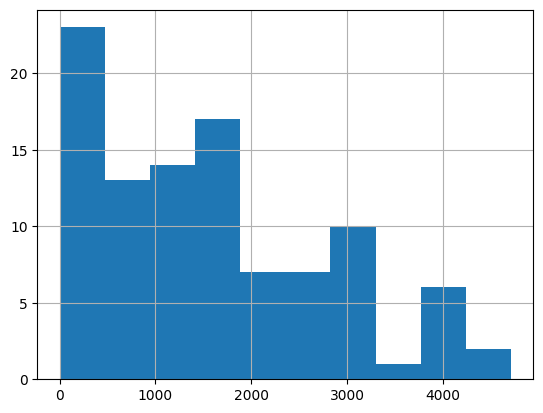

In [6]:
np.random.seed(42)
pd.Series(np.abs(np.random.normal(1000,2000,size=100))).hist()

In [7]:
np.random.seed(42)
parcel_aggr['mass'] = np.round(np.abs(np.random.normal(10000,20000,size=100))).astype(int)

In [9]:
np.random.seed(42)
parcel_aggr['price'] = np.round(np.abs(np.random.normal(10000,40000,size=100))).astype(int)

In [10]:
parcel_aggr['client_type'] = (pd.Series(['Физическое лицо','Юридическое лицо'])
.sample(100,replace=True,random_state=42).values)

In [13]:
parcel_aggr.head()

,parcel_id,accept_date,index_id,mass,price,client_type
0,0,2017-04-07,6,19934,29869,Физическое лицо
1,1,2017-04-20,3,7235,4469,Юридическое лицо
2,2,2017-04-29,7,22954,35908,Физическое лицо
3,3,2017-04-15,4,40461,70921,Физическое лицо
4,4,2017-04-11,6,5317,634,Физическое лицо


Создаем таблицу №2

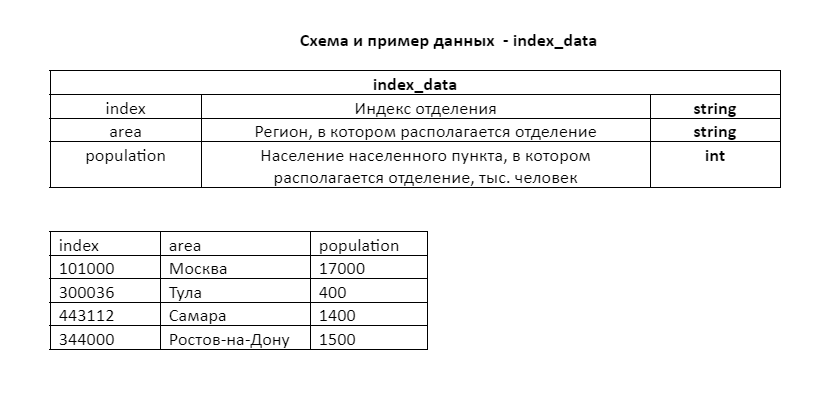

In [14]:
index_data = pd.DataFrame({'index_id':range(10)})

In [15]:
index_data['area'] = ['a','b','c','d','e','f','g','h','i','j']

In [16]:
np.random.seed(42)
index_data['population'] = np.round(np.abs(np.random.normal(10000,40000,size=10))).astype(int)

In [17]:
index_data['population'] = [10000,20002,60000,70000,100001,150000,200000,300000,600000,700000]

# Создаем БД SQLite

In [19]:
con = sqlite3.connect('db')
cur = con.cursor()

In [20]:
def select(sql):
  return pd.read_sql(sql,con)

In [21]:
parcel_aggr.to_sql('parcel_aggr',con,if_exists='replace',index=False)

100

In [24]:
index_data.to_sql('index_data',con,if_exists='replace',index=False)

10

In [25]:
sql = '''select * from index_data t'''

In [ ]:
select(sql)

# Анализ

# Вывести средний размер тарифа на пересылку и массы по индексам отделений, в которых было принято отправление.


In [29]:
sql = '''select t.index_id,

count(t.index_id) as cnt,
 avg(t.price) as price_avg,
 avg(t.mass) as mass_avg

from parcel_aggr t
group by t.index_id
'''

In [ ]:
select(sql)

# Вывести количество отправлений в разрезе индексов отделений, в которых было принято отправление. Учитывать только те отправления, у которых масса  больше  или равна 10 кг.


In [31]:
sql = '''
select
  t.index_id,
  count(t.index_id) as cnt
from parcel_aggr t
where t.mass >= 10000

group by t.index_id
'''

In [35]:
sql = '''select
t.index_id,
count(1) as cnt_all,
count(case when t.mass >= 10000 then 1 else null end) as cnt_10kg,
count(case when t.mass >= 10000 then 1 else null end) * 1.0 / count(1) as pct_10kg

from parcel_aggr t
group by t.index_id
'''

In [ ]:
select(sql)

# Вывести  количество отправлений в разрезе  типа отправителя и группы по численности населения населенного пункта, в котором было принято отправление (меньше 50 тыс. (включительно), от 50 до 100 тыс. (включительно), от 100 до 500 тыс. (включительно), больше 500 тыс.).


In [36]:
sql = '''
select
t.client_type,

case when i.population <= 50000 then '1. до 50'
when i.population <= 100000 then '2. от 50 до 100'
when i.population <= 500000 then '3. от 100 до 500'
else '4. от 500' end as population_group,

count(1) as cnt

from parcel_aggr t
left join index_data i on t.index_id = i.index_id

group by t.client_type,

case when i.population <= 50000 then '1. до 50'
when i.population <= 100000 then '2. от 50 до 100'
when i.population <= 500000 then '3. от 100 до 500'
else '4. от 500' end

order by 1,2

'''

In [ ]:
select(sql)

# Вывести идентификатор отправления; регион, где было принято отправление; численность населения населенного пункта, в котором было принято отправление и стоимость пересылки отправления (в рублях) с максимальной массой в каждом филиале.


In [41]:
sql = '''

select t.parcel_id, t.area, t.population, t.price from

(select
t.*,

i.population,
i.area,

rank() over (partition by t.index_id order by t.mass desc) as rnk

from parcel_aggr t
left join index_data i on t.index_id = i.index_id) t

where t.rnk = 1

'''

In [ ]:
select(sql)

# Вывести идентификаторы отправлений, у которых  масса строго больше, чем в среднем по базе.


In [43]:
sql = '''

select t.parcel_id

 from parcel_aggr t
where t.mass > (select avg(t.mass) as mass_avg from parcel_aggr t)
'''

In [ ]:
select(sql)

# Перед отпуском руководитель попросил вас: «вывести распределение количества отправлений по стоимости пересылки*». Необходимо подготовить 1 слайд, который раскроет данную проблематику.

<Axes: >

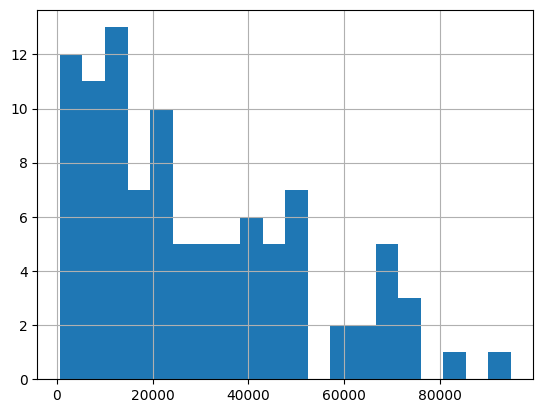

In [45]:
parcel_aggr['price'].hist(bins=20)

In [46]:
parcel_aggr['price_bin'] = pd.cut(parcel_aggr['price'],10)

In [47]:
parcel_aggr.groupby('price_bin')['parcel_id'].count()

price_bin
(522.827, 10034.3]    23
(10034.3, 19451.6]    20
(19451.6, 28868.9]    15
(28868.9, 38286.2]    10
(38286.2, 47703.5]    11
(47703.5, 57120.8]     7
(57120.8, 66538.1]     4
(66538.1, 75955.4]     8
(75955.4, 85372.7]     1
(85372.7, 94790.0]     1
Name: parcel_id, dtype: int64

In [48]:
parcel_aggr['price'].describe()

count      100.00000
mean     28944.73000
std      22536.57919
min        617.00000
25%      10599.50000
50%      23200.50000
75%      43968.25000
max      94790.00000
Name: price, dtype: float64

<Axes: title={'center': 'price'}, xlabel='index_id'>

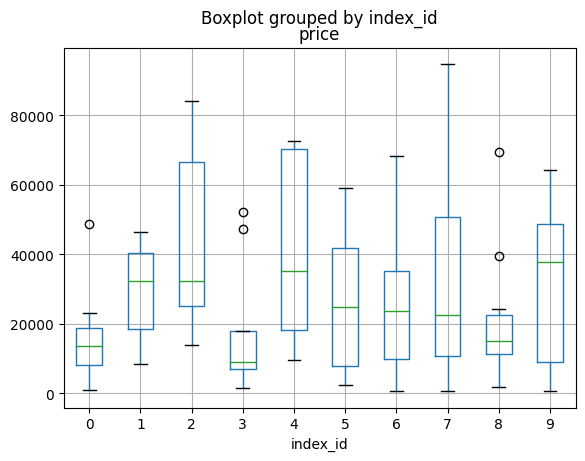

In [49]:
parcel_aggr.boxplot('price',by='index_id')